In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from scipy import sparse
import time

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel
from tqdm import tqdm

from torch_lr_finder import LRFinder

import utils
from importlib import reload

reload(utils)

from scipy import sparse

In [2]:
from sparselinear import SparseLinear

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
else:
    device = torch.device("cpu")

Using GPU


## Files

In [4]:
DATASET = 'cite'

data_dir = '/home/artemy/multimodal_proj/data/competition/'
log_dir = '/home/artemy/multimodal_proj/cur_model_tb'
o_dir = '/home/artemy/multimodal_proj/data/AE_predictions/'


cite_inputs_train_fn = data_dir + "cite_gex_train.sparse.npz"
cite_targets_train_fn = data_dir + "cite_adt_train.sparse.npz"
cite_inputs_test_fn = data_dir + "cite_gex_test.sparse.npz"

sparse_dir = '/home/artemy/multimodal_proj/data/sparse/'
peak_connections_file = f'{sparse_dir}protein_interactions.npz'


In [5]:
peak_connections = sparse.load_npz(peak_connections_file).astype(int)
connected_peaks = np.asarray(peak_connections.sum(1) != 0).reshape(-1)
peak_connections = peak_connections[connected_peaks]

In [6]:
cite_inputs = sparse.load_npz(cite_inputs_train_fn)
cite_inputs = cite_inputs[:, connected_peaks]
cite_inputs = np.asarray(cite_inputs.todense()).astype(np.float32)

In [7]:
tuning_data_dir = '/home/artemy/multimodal_proj/data/tuning_data/'
cite_inputs_transformed = utils.load_sparse_data(tuning_data_dir + 'cite_gex_train_svd.sparse.npz')
cite_inputs_transformed = cite_inputs_transformed[:, :101]

In [8]:
mixed_cite_inputs = np.concatenate((cite_inputs, cite_inputs_transformed), 1)

In [9]:
cite_targets = utils.load_sparse_data(cite_targets_train_fn)

In [10]:
metadata = pd.read_csv(data_dir + 'metadata.csv')
cell_labels = pd.read_csv(data_dir + 'cell_labels_cite_train.csv', usecols=[1])
train_assay_meta = pd.merge(cell_labels, metadata, left_on='0', right_on='cell_id')
val_idx = np.where(train_assay_meta['day'] != 4)[0]

In [11]:
cite_train_loader, cite_val_loader = utils.make_loaders(mixed_cite_inputs, cite_targets, batch_size=1024, num_workers=1)


## Model:

In [12]:
class Universal_Model(nn.Module, utils.HyperParameters):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 layers_sizes = [512] * 4,
                 concat_pos = 4,
                 n_of_layers_to_concat = 3,
                 dropout = 1,
                 device = 'cpu',
                 **kwargs 
    ):
        super().__init__()
        self.save_hyperparameters()
        self.layers_sizes = [self.input_dim] + self.layers_sizes + [self.output_dim]
        self.n_layers = len(self.layers_sizes) - 1
        modules = []
        for i in range(self.n_layers):
            if i != self.concat_pos:
                input_dim = self.layers_sizes[i]
            else:
                input_dim = sum(self.layers_sizes[self.concat_pos-self.n_of_layers_to_concat+1:self.concat_pos+1])
            output_dim = self.layers_sizes[i + 1]
            if i == self.n_layers-1 and dropout != 1:
                modules.append(nn.Dropout1d(dropout))
            modules.append(nn.Linear(input_dim, output_dim))
            modules.append(nn.BatchNorm1d(num_features=output_dim))          
            modules.append(nn.SiLU())
        self.net = nn.Sequential(*modules)
        self.net.apply(lambda x: utils.init_weights(x, activation='relu'))
    
    def forward(self, x):
        fc_layer_n = 0
        layer_outputs = []
        for module in self.net:
            if fc_layer_n == self.concat_pos and isinstance(module, nn.Linear):
                x = torch.concat(layer_outputs[-self.n_of_layers_to_concat:], 1)
            x = module(x)
            if isinstance(module, nn.SiLU):
                layer_outputs.append(x)
            if isinstance(module, nn.Linear):
                fc_layer_n += 1
        return x

In [13]:
class Sparse_Model(nn.Module, utils.HyperParameters):
    def __init__(self,
                 peak_connections,
                 device = 'cpu',
                 nPCs = 100,
                 **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()
        
        self.block2_params = {'layers_sizes': [252, 357, 364],
                             'concat_pos': 4,
                             'n_of_layers_to_concat': 2,
                             'dropout': 0.016973414031438438,
                             'input_dim': self.nPCs,
                             'output_dim': 183}
        
        self.initialize_connectivity()
        
        input_dim = self.peak_connections.shape[0] 
        output_dim = self.n_connected_genes * self.multiplier
        layer = SparseLinear(input_dim, output_dim, connectivity=self.connectivity)
        bn = nn.BatchNorm1d(num_features=output_dim) 
        act = nn.SiLU()
        
        #input_dim = output_dim 
        #output_dim = input_dim
        #layer2 = SparseLinear(input_dim, output_dim, connectivity=self.next_connectivity)
        #bn2 = nn.BatchNorm1d(num_features=output_dim) 
        #act2 = nn.SiLU()
        
        self.block1 = nn.Sequential(layer, bn, act)#, layer2, bn2, act2)
        
        self.block2 = Universal_Model(**self.block2_params)
        
        input_dim = self.n_connected_genes * self.multiplier + self.block2_params['output_dim']
        output_dim = self.n_genes
        #layer = SparseLinear(input_dim, output_dim, connectivity=self.reverse_connectivity)
        layer = nn.Linear(input_dim, output_dim)
        #bn = nn.BatchNorm1d(num_features=output_dim) 
        #act = nn.SiLU()
        self.block3 = nn.Sequential(layer)#, act)
        
        
        self.block1.apply(utils.init_weights)
        self.block2.apply(utils.init_weights)
        self.block3.apply(utils.init_weights)

        
    def initialize_connectivity(self):
        reformat = lambda x: torch.tensor(x).reshape(1, -1).long()
        
        non_empty_connections_mask = np.asarray(self.peak_connections.sum(0) != 0).reshape(-1)
        non_empty_connections = peak_connections[:, non_empty_connections_mask]
        
        #bottom_m = sparse.csr_matrix(np.zeros((self.nPCs, non_empty_connections.shape[1])))
        #non_empty_connections = sparse.vstack((non_empty_connections, bottom_m), format='csr')
        #right_m = sparse.csr_matrix(np.zeros((non_empty_connections.shape[0], self.nPCs)))
        #non_empty_connections = sparse.hstack((non_empty_connections, right_m), format='csr')
        #non_empty_connections[-self.nPCs:, -self.nPCs:] = 1
        
        non_empty_connections = non_empty_connections.tocoo()
        
        self.n_genes = self.peak_connections.shape[1]
        self.n_connected_genes = sum(non_empty_connections_mask)
        
        self.multiplier = 10 
        
        con_col = reformat(np.tile(non_empty_connections.row, self.multiplier))
        con_row = reformat(np.concatenate([non_empty_connections.col + i * self.n_connected_genes for i in range(self.multiplier)]))

        self.connectivity = torch.cat((con_row, con_col), dim=0)
        
        next_cols = np.repeat(np.arange(self.n_connected_genes * self.multiplier), self.multiplier)
        next_rows = np.repeat(np.arange(self.n_connected_genes), self.multiplier * self.multiplier) \
                                + np.tile([self.n_connected_genes * i for i in range(self.multiplier)], self.n_connected_genes * self.multiplier)

        self.next_connectivity = torch.cat((reformat(next_rows), reformat(next_cols)), dim=0)

        rev_con_row = reformat(np.tile(np.where(non_empty_connections_mask)[0], self.multiplier))
        rev_con_col = reformat(np.arange(self.n_connected_genes * self.multiplier))
        
        
        #rev_con_row = reformat(np.where(non_empty_connections_mask)[0])
        #rev_con_col = reformat(np.arange(self.n_connected_genes))

        PC_row = reformat(np.tile(np.arange(self.n_genes), self.block2_params['output_dim']))
        PC_col = reformat(np.repeat(np.arange(self.n_connected_genes * self.multiplier, 
                                              self.n_connected_genes * self.multiplier + self.block2_params['output_dim']), self.n_genes))
        
        #print(torch.max(PC_row.T), torch.max(PC_col.T))
        rev_con_row = torch.cat((rev_con_row, PC_row), axis=1)       
        rev_con_col = torch.cat((rev_con_col, PC_col), axis=1)
        #print(max(rev_con_row.T), max(rev_con_col.T))
        
        self.reverse_connectivity = torch.cat((rev_con_row, rev_con_col), axis=0)
        
        
    def forward(self, x):
        block1_out = self.block1(x[:, :-self.nPCs])
        block2_out = self.block2(x[:, -self.nPCs:])
        block3_in = torch.cat((block1_out, block2_out), 1)
        block3_out = self.block3(block3_in)
        return block3_out
        

In [14]:
class Special_Trainer(utils.Trainer):
    def fit(self, return_val_loss=False, verbose=True):
        self.verbose = verbose
        self.steps_per_epoch = self.train_loader.nb_batches
        self.prepare_model()
        self.optim = self.configure_optimizers()
        self.progress = {'train': [], 'val':[]}
        self.epoch = 0
        self.n_iter = {'train': 0, 'val': 0}
        for self.epoch in tqdm(range(self.max_epochs)):
            self.fit_epoch()
            self.epoch += 1
            
        if self.verbose:
            print('Training cor: %.3f' % np.mean(self.progress['train']),
                  'Validation cor: %.3f' % np.mean(self.progress['val']), sep='\n')
        if return_val_loss:
            return np.mean(self.progress['val'])
        
    def process_batch(self, split='train'):
        self.batch_inputs, self.batch_targets = self.batch_inputs.to(self.device), self.batch_targets.to(self.device)
        
        pred = self.model.forward(self.batch_inputs)

        pred_loss = self.MSE_loss(pred, self.batch_targets)
        #pc_params = self.model.block3[0].connectivity[1][-self.model.n_genes * self.model.block2_params['output_dim']:]
        #pc_l2_loss = torch.sum(torch.pow(pc_params, 2))
        loss = pred_loss# + pc_l2_loss * 5


        cor = utils.spearman_cor(pred, self.batch_targets)

        if split == 'train':
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()

        if self.use_tensor_board:
            self.writer.add_scalar(f'{split} loss', pred_loss, self.n_iter[split])
            self.writer.add_scalar(f'{split} cor', cor, self.n_iter[split])
        self.n_iter[split] += 1
        if self.epoch == self.max_epochs - 1:
            self.progress[split].append(float(cor))
    
    def fit_epoch(self):
        self.model.train()
        for self.train_batch_idx, (self.batch_inputs, self.batch_targets) in enumerate(self.train_loader):
            self.process_batch(split='train')
            
        with torch.no_grad():
            self.model.eval()
            for self.train_batch_idx, (self.batch_inputs, self.batch_targets) in enumerate(self.val_loader):
                self.process_batch(split='val')
            
        
    def transform(self, test_loader):
        with torch.no_grad():
            self.model.eval()
            outputs = []
            for batch_inputs in test_loader:
                if type(batch_inputs) == list or type(batch_inputs) == tuple:
                    batch_inputs = batch_inputs[0]
                batch_inputs = batch_inputs.to(self.device)
                batch_outputs = self.model.forward(batch_inputs)
                outputs.append(batch_outputs.to('cpu').detach().numpy())
            return np.concatenate(outputs)

## Train model

In [15]:
# generic parameters
trainer_params = {
                  'device': device, 
                  'wd': 1.9924782602665775e-05,
                  'lr': 0.021244381323042003 
                 }

# configure model
model = Sparse_Model

model_params = {'peak_connections': peak_connections, 'nPCs': 101}


# best variant
trainer_params['use_one_cycle'] = 1

trainer_params['max_epochs'] = 20


In [16]:
writer = SummaryWriter(log_dir=log_dir)
trainer = Special_Trainer(**trainer_params, writer = writer)
trainer.add_train_loader(cite_train_loader)
trainer.add_val_loader(cite_val_loader)

In [17]:
%%time
train_model = 1
if train_model:
    trainer.add_model(model, model_params)
    trainer.fit()

100%|███████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]

Training cor: 0.908
Validation cor: 0.890
CPU times: user 16min 9s, sys: 37.4 s, total: 16min 46s
Wall time: 24.5 s


In [18]:
model_file = f'{o_dir}model_sparse.pt'

save_model = 1
if save_model:
    trainer.save_model(model_file)

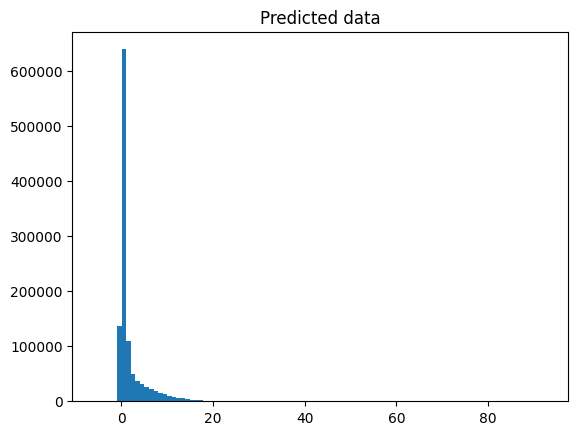

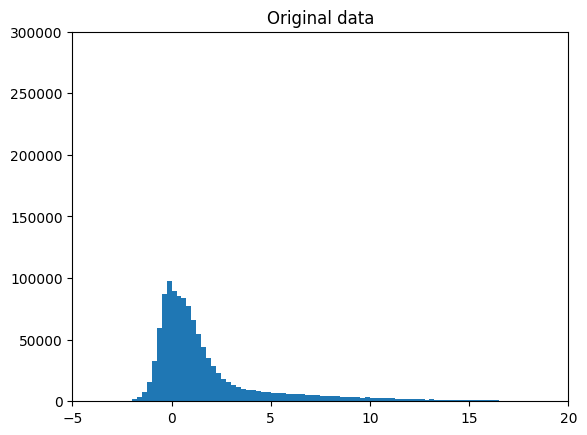

In [19]:
analyze_pred = 1
if analyze_pred:
    model_params = {}
    model_params['nPCs'] = 101
    model_params['peak_connections'] = peak_connections
    trainer.add_model(model, model_params)
    trainer.load_model(model_file)
    rna_pred, rna_orig = trainer.analyze_model(trainer.val_loader)
    #utils.plot_model_analysis(rna_pred, rna_orig)

    plt.hist(rna_pred.flatten(), bins=100)
    plt.title('Predicted data')

    plt.show()
    plt.hist(rna_orig.flatten(), bins=100, range=(-5, 20))
    plt.ylim((0, 300000))
    plt.xlim((-5, 20))
    plt.title('Original data')

## Make predictions

In [39]:
pred_file_multi = o_dir + "multi_gex_pred_rnn.npy"
pred_file_cite = o_dir + "cite_adt_pred_rnn.npy"

In [41]:
make_predictions = True
if make_predictions:
    trainer = Special_Trainer(**trainer_params)
    model_params['atac_dim'] = multi_train_loader.input_dim
    model_params['rna_dim'] = multi_train_loader.output_dim
    model_params['prot_dim'] = multi_train_loader.output_dim
    trainer.add_model(model, model_params)
    trainer.load_model(model_file)
    
    
    outputs = trainer.transform(multi_test_loader, 'atac')
    outputs = rna_svd.inverse_transform(outputs)
    
    outputs = 
    
    with open(pred_file_cite, 'wb') as f:
        np.save(f, outputs)